In [1]:
#### This notebook contains the code that will load the pre-trained weights for the gender detector model available in the deep face package
#### Author: Hugo Albuquerque Cosme da Silva
#### Creation date: 2023-12-24

# Imports

In [1]:
import os
import gdown
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from deepface.basemodels import VGGFace
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Activation
import cv2


2023-12-31 21:25:07.616821: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 21:25:07.651684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 21:25:07.651710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 21:25:07.652627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 21:25:07.657851: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 21:25:07.658592: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Labels for the genders that can be detected by the model.
labels = ["Woman", "Man"]

In [3]:
def loadModel(
    url="https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5",
) -> Model:
    
    model = VGGFace.baseModel()

    # --------------------------

    classes = 2
    base_model_output = Sequential()
    base_model_output = Convolution2D(classes, (1, 1), name="predictions")(model.layers[-4].output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation("softmax")(base_model_output)

    # --------------------------

    gender_model = Model(inputs=model.input, outputs=base_model_output)

    # --------------------------

    # load weights
    output = "/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/model_weights/gender_model_weights.h5"
    if os.path.isfile(output) != True:
        gdown.download(url, output, quiet=False)

    gender_model.load_weights(output)

    return gender_model
    

# Loading the model

In [4]:
model = loadModel()

2023-12-31 21:25:16.952780: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-12-31 21:25:17.071341: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-12-31 21:25:17.113118: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/model_weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:38<00:00, 14.0MB/s] 
2023-12-31 21:25:57.817082: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

# testing the model

I have downloaded the UTKFace dataset from kaggle and now I will try to see if the model is making reasonable predicions.<br>
link to download the dataset: https://www.kaggle.com/datasets/jangedoo/utkface-new

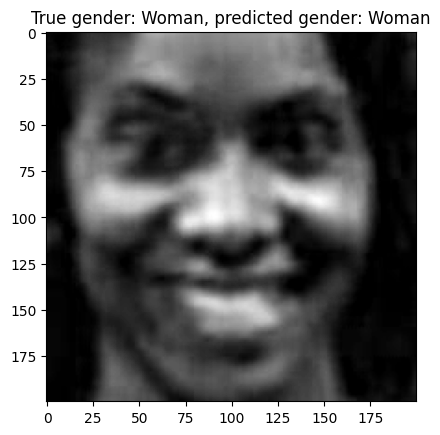

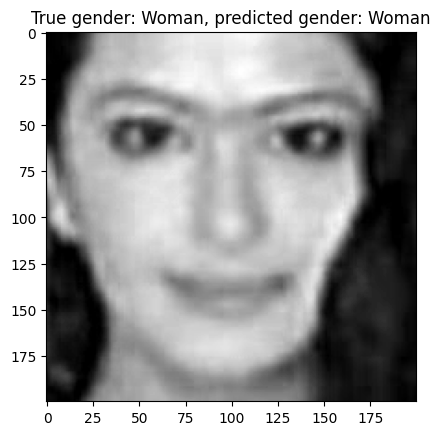

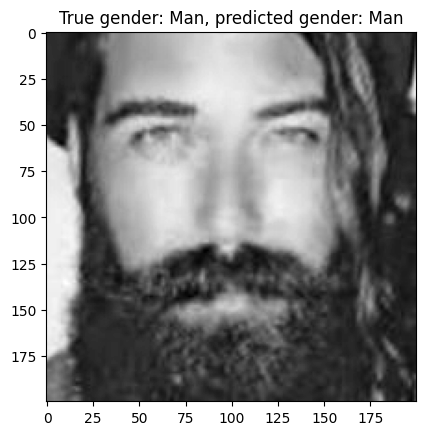

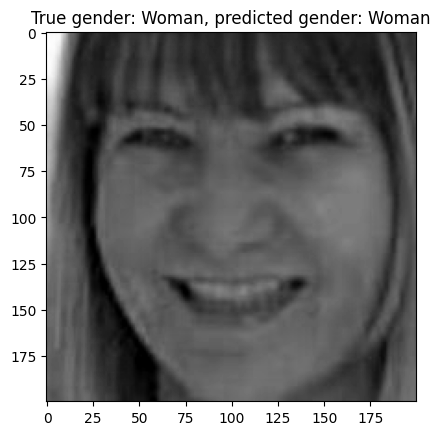

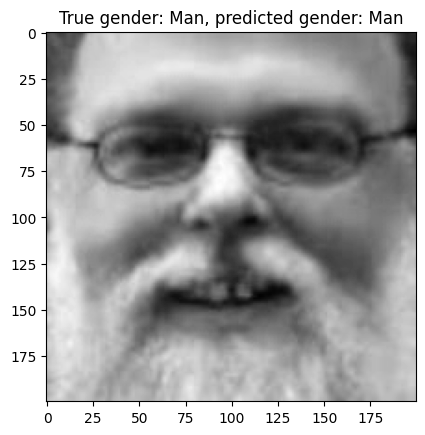

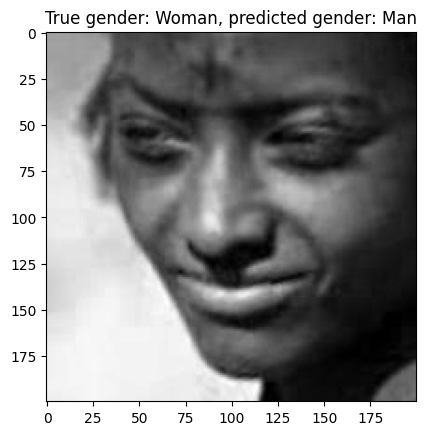

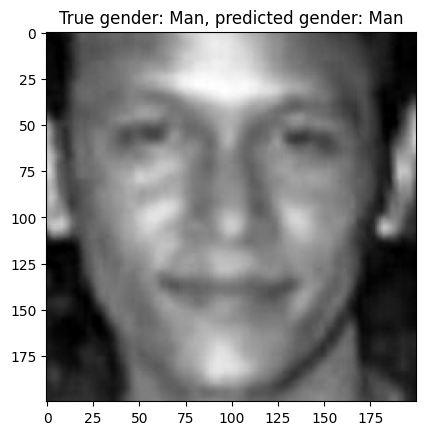

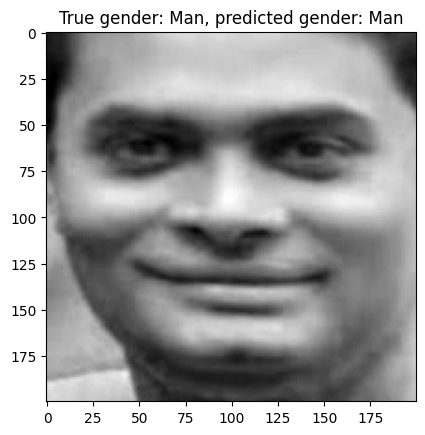

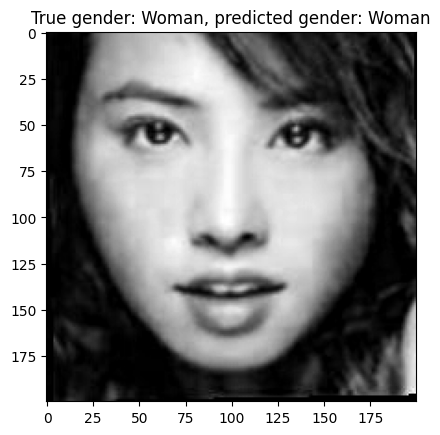

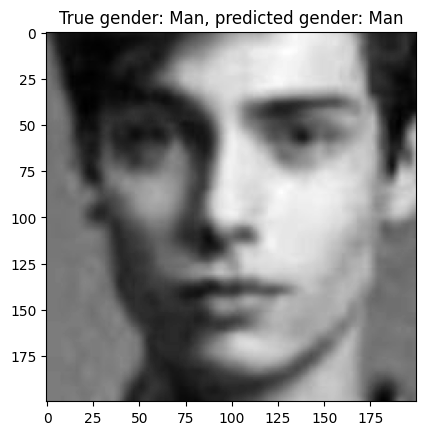

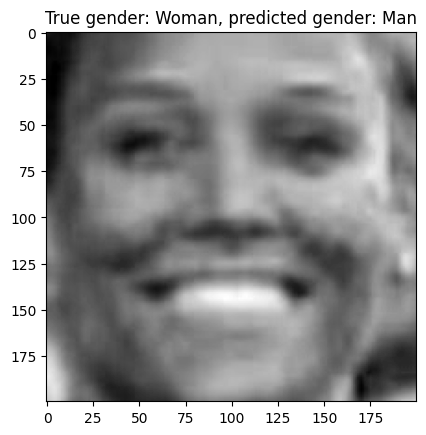

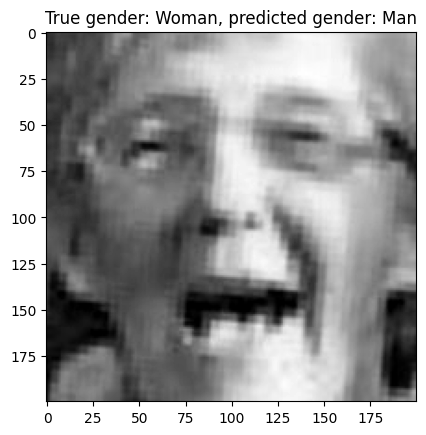

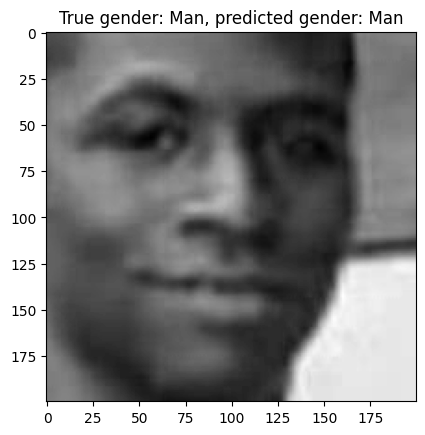

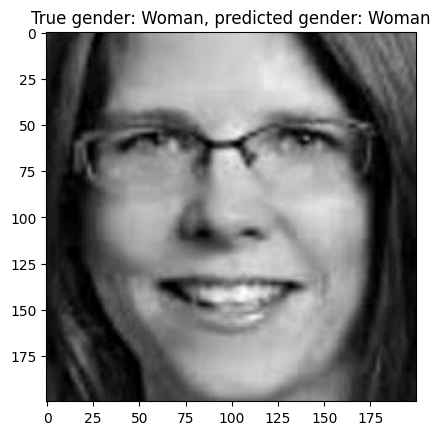

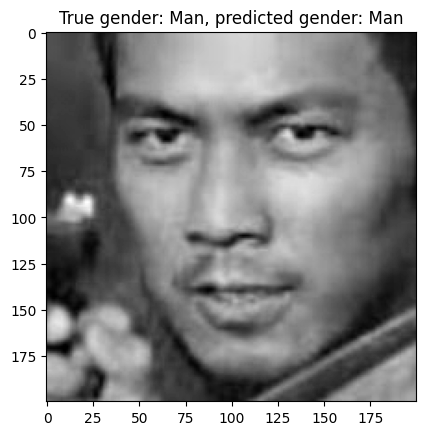

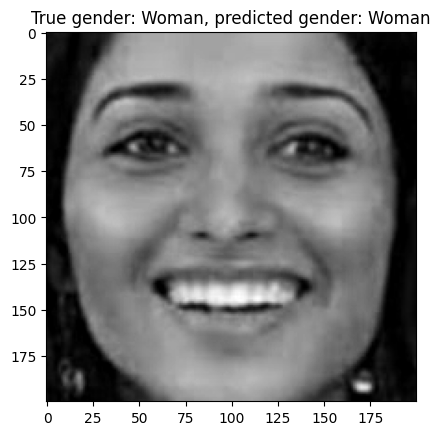

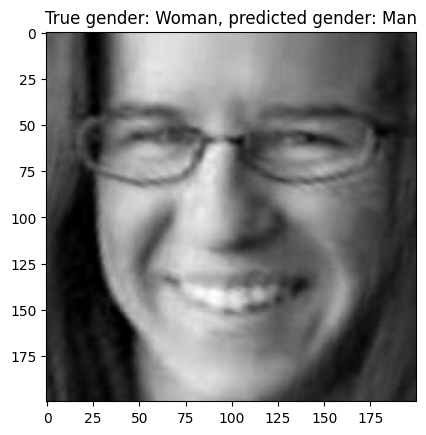

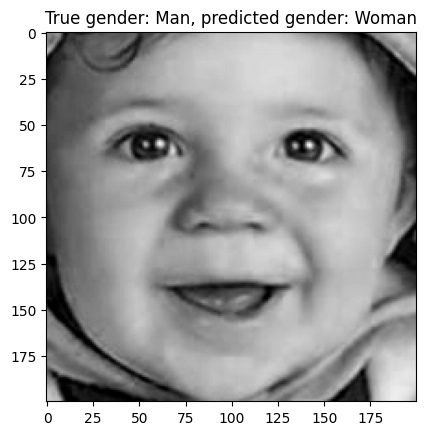

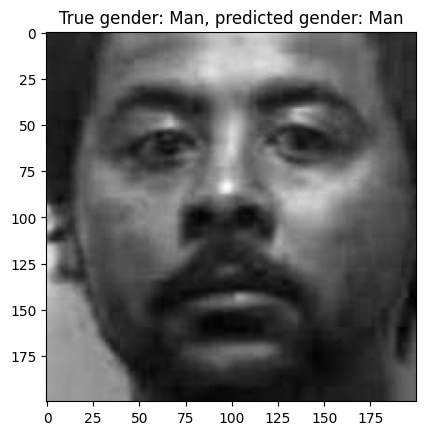

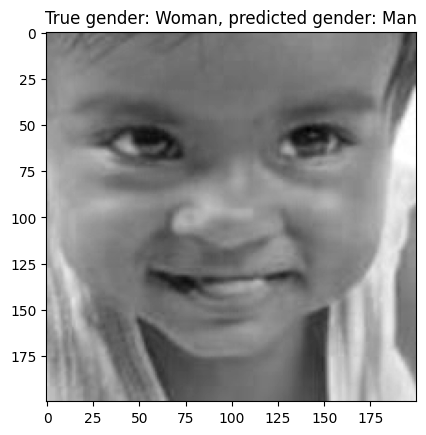

In [6]:
# testing the model on 20 random images
path = "/home/hualcosa/Documents/iu_project_edge_ai/project_files/UTKFace"


for _ in range(20):
    img = random.choice(os.listdir(path))
    # following UTK dataset filename convetion explained in the dataset website
    gender = 'Woman' if int(img.split("_")[1]) else 'Man'
    img = cv2.imread(os.path.join(path, img))

    img_copy = img.copy()
    # resizing image
    img = cv2.resize(img, (224, 224))
    # scaling image
    img = img / 255
    # adding batch dimension
    img = np.expand_dims(img, axis=0)
    # performing inference
    pred_gender = labels[np.argmax(model.predict(img, verbose=0))]

    # taking a glimpse at predicted age vs true age
    plt.imshow(img_copy[:,:,0], cmap='gray')
    plt.title(f"True gender: {gender}, predicted gender: {pred_gender}")
    plt.show()

# Saving model

In [19]:
tf.saved_model.save(model, export_dir="/home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/gender")

INFO:tensorflow:Assets written to: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/gender/assets


INFO:tensorflow:Assets written to: /home/hualcosa/Documents/iu_project_edge_ai/project_files/artifacts/models/gender/assets


# Evaluating the performance in the evaluation images
In this section I will evaluate the performance of the saved model(BEFORE CONVERTION TO TF-LITE format) on a test-set of 20 images. These images that will also be used to evaluate the perfomance of the deployed models in the Android application

In [7]:
img_paths = '/home/hualcosa/Documents/iu_project_edge_ai/evaluation_images'
img_paths = [os.path.join(img_paths, i) for i in os.listdir(img_paths)]

In [9]:
# This list is going to store the comparison between true class vs predicted class.
evals = []
for path in img_paths:
    # retrieving the original names from the file names:
    age_label, gender_label, emotion_label, _ = path.split('/')[-1].split("_")
    # read image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_orig = img.copy() 
    # the model expects data in float32 format
    img = img.astype('float32')
    img_gender_age = cv2.resize(img, (224,224))
    img_gender_age = img_gender_age.reshape(1, 224, 224, 3) / 255 # normalizing the img

    predicted_label = labels[model.predict(img_gender_age, verbose=0).argmax()] 

    evals.append(int(gender_label == predicted_label.lower()))

In [10]:
print(f"The original model accuracy is: {100 * sum(evals)/ len(evals)} %")

The original model accuracy is: 87.5 %
